In [2]:
import os
import csv
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
from scipy.integrate import solve_ivp

os.makedirs('./figures', exist_ok=True)
os.makedirs('./result', exist_ok=True)

In [ ]:
N = 500
cmap = plt.cm.viridis
x0 = np.random.rand(N)

def lorenz96_rhs(x, F):
    N = len(x)
    dxdt = np.zeros(N)
    for i in range(N):
        dxdt[i] = (x[(i+1)%N] - x[(i-2)%N]) * x[(i-1)%N] - x[i] + F
    return dxdt

def runge_kutta_4th_order(x0, F, dt, T):
    N = len(x0)
    num_steps = int(T/dt)
    x = np.zeros((num_steps, N))
    x[0, :] = x0
    for i in range(1, num_steps):
        k1 = lorenz96_rhs(x[i-1, :], F)
        k2 = lorenz96_rhs(x[i-1, :] + 0.5*dt*k1, F)
        k3 = lorenz96_rhs(x[i-1, :] + 0.5*dt*k2, F)
        k4 = lorenz96_rhs(x[i-1, :] + dt*k3, F)
        x[i, :] = x[i-1, :] + dt/6.0 * (k1 + 2*k2 + 2*k3 + k4)
    return x
    
def plot_trajectory(F, T, dt, x0, N=500, en_cbar=False, save=False):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    x = runge_kutta_4th_order(x0, F, dt, T)
    num_steps = x.shape[0]
    color_values = np.linspace(0, 1, num_steps)
    linewidth_values = np.linspace(0.5, 3, num_steps)
    for j in range(1, num_steps):
        ax.plot(x[j-1:j+1, 0], x[j-1:j+1, 1], x[j-1:j+1, 2], color=cmap(color_values[j]), linewidth=linewidth_values[j])

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')

    if en_cbar:
    # Add a colorbar for time to each figure
        cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cbar_ax)
        cbar.set_label('')
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['0', f'{T}'])
        cbar.ax.tick_params(labelsize=24)

    if save:
        plt.savefig(f'./figures/lorenz_F{F}_traj.eps', format='eps')
        plt.savefig(f'./figures/lorenz_F{F}_traj.png', format='png')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


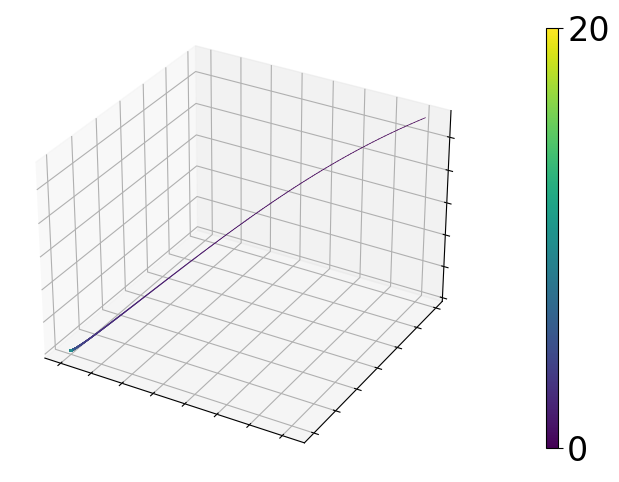

In [17]:
plot_trajectory(F=0.1, T=20, dt=0.01, x0=x0, N=500, en_cbar=True, save=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


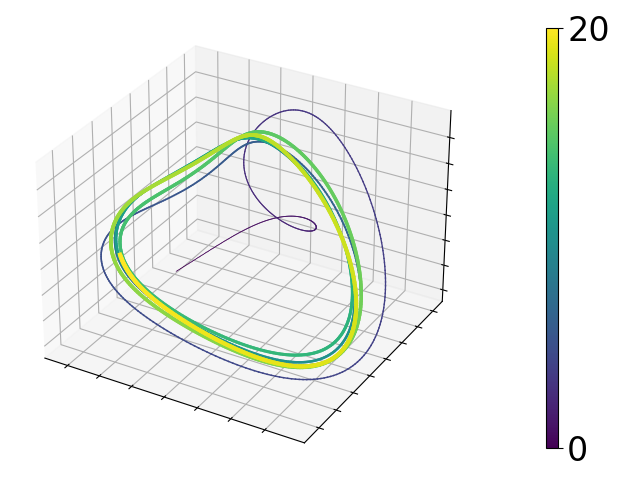

In [18]:
plot_trajectory(F=2, T=20, dt=0.01, x0=x0, N=500, en_cbar=True, save=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


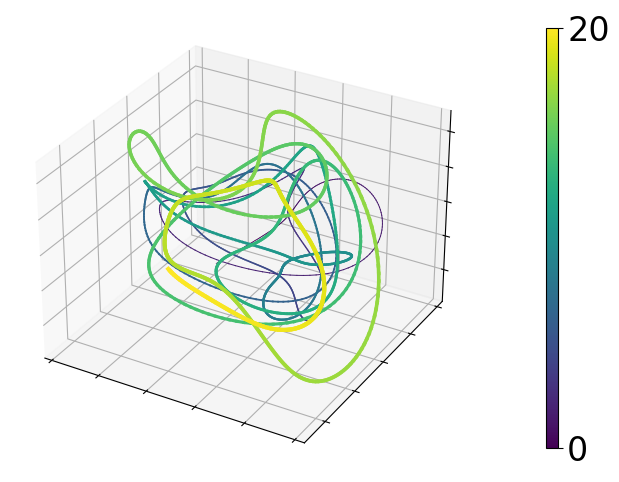

In [29]:
plot_trajectory(F=4.5, T=20, dt=0.01, x0=x0, N=500, en_cbar=True, save=True)

## 2. Bifurcation Map

In [4]:
def lorenz96(t, x, F):
    N = len(x)
    dxdt = np.zeros(N)
    for i in range(N):
        dxdt[i] = (x[(i+1) % N] - x[i-2]) * x[i-1] - x[i] + F
    return dxdt

def bifurcation_diagram(F_values, N=500, T=2.5, dt=0.01):
    # Initial conditions with values between -10 and 10
    x0 = 20 * np.random.rand(N) - 10
    
    x_values = []
    f_values = []
    
    for F in F_values:
        sol = solve_ivp(lorenz96, [0, T], x0, args=(F,), t_eval=np.arange(0, T, dt), method='RK45')
        x0 = sol.y[:, -1]  # Set the final state as the initial state for the next integration
        
        # Store the last few states to plot in the bifurcation diagram
        x_values.extend(sol.y[0, -int(T/2/dt):])  # Taking states of the first variable as an example, selects the last half of the time points in the solution.
        f_values.extend([F] * len(sol.y[0, -int(T/2/dt):]))
    
    return f_values, x_values

Text(0.5, 1.0, '')

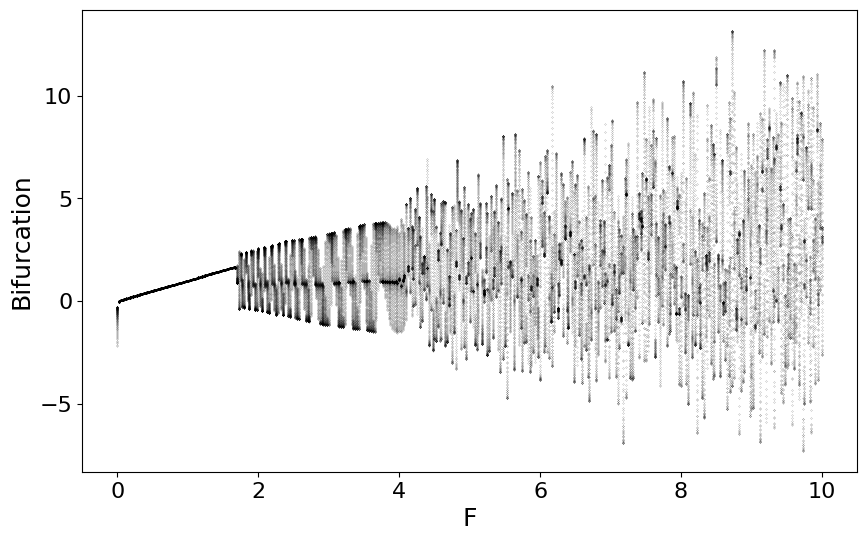

In [31]:
# Values of F
F_values = np.linspace(0, 10, 400+1)
f_values, x_values = bifurcation_diagram(F_values)

plt.figure(figsize=(10, 6))
plt.scatter(f_values, x_values, s=0.01, c='black')
plt.xlabel('F', fontsize=18)
plt.ylabel('Bifurcation', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('')
# plt.savefig(f'./figures/lorenz_t2.5_bifurcation.eps', format='eps')
# plt.savefig(f'./figures/lorenz_t2.5_bifurcation.png', format='png')

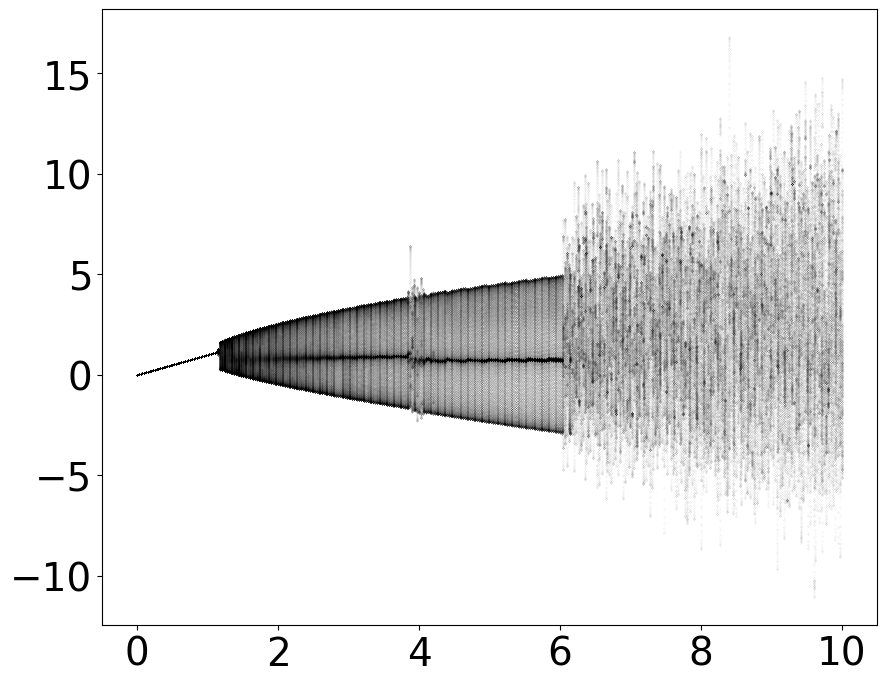

In [8]:
# Values of F
# F_values = np.linspace(0, 10, 400+1)
# f_values, x_values = bifurcation_diagram(F_values, T=20)

plt.figure(figsize=(10, 8), dpi=100)
plt.scatter(f_values, x_values, s=0.0005, c='black')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.title('')
# plt.savefig(f'./figures/lorenz_t20_bifurcation.eps', format='eps')
plt.savefig(f'./figures/lorenz_t20_bifurcation.png', format='png')

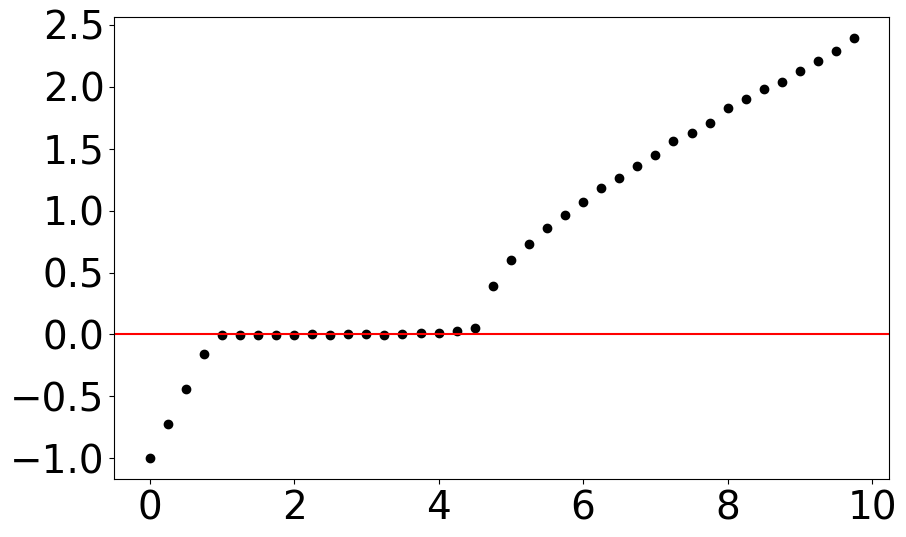

In [35]:
df = pd.read_csv('./result/MLE.csv', header=None, names=['f', 'values'])

plt.figure(figsize=(10, 6))
plt.scatter(df['f'], df['values'], marker='o', color='black')
plt.axhline(y=0, color='red', linestyle='-')
# plt.axvline(x=4.5, color='green', linestyle='--')
# plt.text(4.5, min(df['values'])-0.1, 'F=4.5', rotation=0, verticalalignment='bottom', horizontalalignment='center', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.grid(False)
plt.savefig(f'./figures/lorenz_t20_gle.eps', format='eps')
plt.savefig(f'./figures/lorenz_t20_gle.png', format='png')

### MNIST Bifurcation (need training first!)

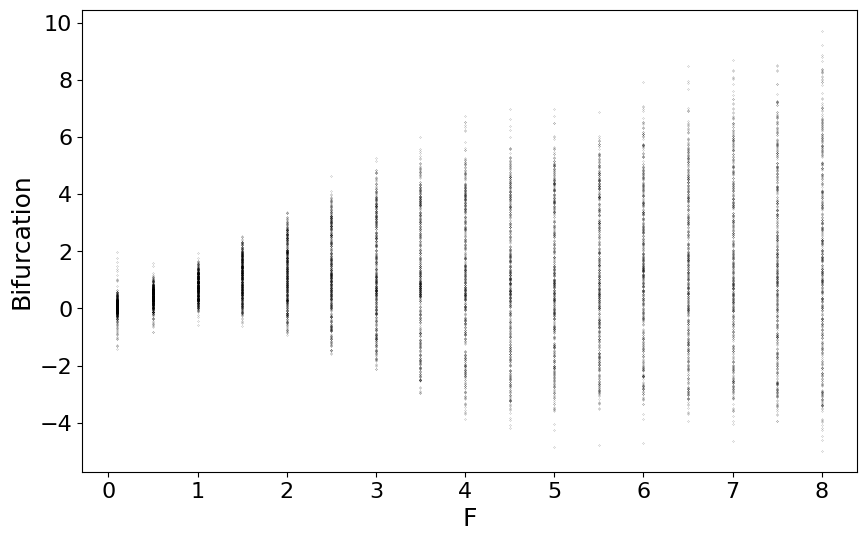

In [42]:
# Load MNIST test data
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST('../data', train=False, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# Define values for F
F_values = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]

def plot_bifurcation_for_single_mnist_image(image, F_values):
    x_values_list = []
    f_values_list = []

    for F in F_values:
        config = {
            "f": F,
            "iteration": 2.5,
        }
        model = lorenz96.ODEBlock(input_size=28*28, output_size=10, systemCount=500, config=config)
        checkpoint = torch.load(f'./save_models/lorenz_f{F}_t2.5.pth')
        model.load_state_dict(checkpoint)
        model = model.to("cuda")
        image = image.to("cuda")

        # Forward propagate the single image to get the states
        model.forward(image)
        states = model.finalStates

        x_values_list.extend(states.squeeze().tolist())
        f_values_list.extend([F] * states.shape[1])

    # Plot the bifurcation diagram
    plt.figure(figsize=(10, 6))
    plt.scatter(f_values_list, x_values_list, s=0.01, c='black')
    plt.xlabel('F', fontsize=18)
    plt.ylabel('Bifurcation', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

# Use the first image from the test dataloader as an example
image, label = next(iter(test_dataloader))
image = image[10].view(1, 28*28)  # take the first image and reshape

# Call the plotting function
plot_bifurcation_for_single_mnist_image(image, F_values)

  0%|          | 0/17 [00:00<?, ?it/s]

/home/isi/s-liu/.local/lib/python3.8/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
100%|██████████| 17/17 [00:03<00:00,  4.53it/s]


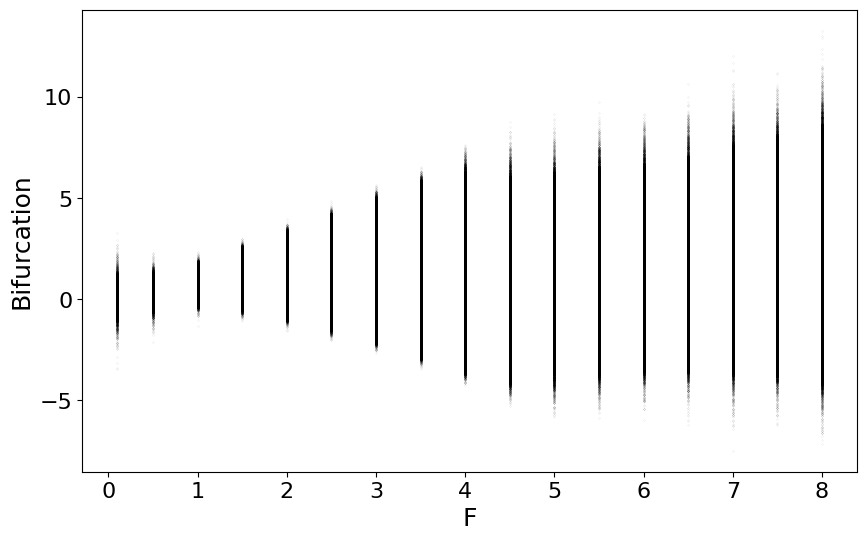

In [48]:
batch_size = 100
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST('../data', train=False, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define values for F
F_values = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]

def plot_bifurcation_for_batch_mnist_images(images, F_values):
    x_values_list = []
    f_values_list = []

    for F in tqdm(F_values):
        config = {
            "f": F,
            "iteration": 2.5,
        }
        model = lorenz96.ODEBlock(input_size=28*28, output_size=10, systemCount=500, config=config)
        checkpoint = torch.load(f'./save_models/lorenz_f{F}_t2.5.pth')
        model.load_state_dict(checkpoint)
        model = model.to("cuda")
        images = images.to("cuda")

        # Forward propagate the batch of images to get the states
        model.forward(images)
        states = model.finalStates

        for state in states:
            x_values_list.extend(state.squeeze().tolist())
            f_values_list.extend([F] * state.shape[0])

    # Plot the bifurcation diagram
    plt.figure(figsize=(10, 6))
    plt.scatter(f_values_list, x_values_list, s=0.001, c='black')
    plt.xlabel('F', fontsize=18)
    plt.ylabel('Bifurcation', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

    return f_values_list, x_values_list

# Use the first batch of images from the test dataloader
images, labels = next(iter(test_dataloader))
images = images.view(batch_size, 28*28)  # take the first image and reshape

# Call the plotting function
f_values_list, x_values_list = plot_bifurcation_for_batch_mnist_images(images, F_values)

In [56]:
assert len(x_values_list) == len(f_values_list)

# directory = './bifurcation/'
# if not os.path.exists(directory):
#     os.makedirs(directory)
    
filename = "./result/bifurcation/2.5t.csv"
with open(filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # Write header
    csv_writer.writerow(['x', 'f'])
    
    # Write data
    for x, f in zip(x_values_list, f_values_list):
        csv_writer.writerow([x, f])